## CNN that predicts angle

A simple CNN with one output - a number represents angle of rotation. 

We use this angle to rotate picture back. As a visual indicator of rotation we use drawn rectangles.

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from dataset_helper import DataSet, rotate
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load train data
rows    = pd.read_csv('datalog_train.csv')
angles  = rows['angle'].tolist()
samples = rows['image'].tolist()
print("Number of training samples: ", len(angles))

Number of training samples:  11000


In [3]:
# load test data
rows_test    = pd.read_csv('datalog_test.csv')
angles_test  = rows_test['angle'].tolist()
samples_test = rows_test['image'].tolist()
print("Number of test samples: ", len(samples_test))

Number of test samples:  1000


In [4]:
# split
shuffle(samples, angles)
samples_train, samples_valid, angles_train, angles_valid = train_test_split(samples, angles, test_size=0.3)

In [5]:
data_train = DataSet(angles_train, samples_train)
data_valid = DataSet(angles_valid, samples_valid, 'valid')
# check
print("Number of train samples: ", len(data_train.sample_paths))
print("Number of valid samples: ", len(data_valid.sample_paths))

Number of train samples:  7700
Number of valid samples:  3300


## Build Network

In [6]:
# constants
size          = data_train.size # images shape 128x128
epochs        = 1500
learning_rate = 1e-4
decay_freq    = 200
labels        = np.unique(data_train.angles)

In [7]:
# tensorflow graph placeholders
images_ph = tf.placeholder(tf.float32, (None, size, size, 3), name='images')
angles_ph = tf.placeholder(tf.float32, (None), name='angles')

In [8]:
# cnn architecture
def conv2d(inputs, filters):
    layer = tf.layers.conv2d(inputs=inputs,
                             filters=filters,
                             kernel_size=[3, 3],
                             strides=(1, 1),
                             padding='valid',
                             activation=tf.nn.relu)
    layer = tf.layers.batch_normalization(layer, training=True)
    layer = tf.nn.relu(layer)
    layer = tf.layers.max_pooling2d(layer, pool_size=[2, 2], strides=2)
    return layer

def build_cnn(inputs):
    layer1 = conv2d(inputs=inputs, filters=24)
    print("layer1: ", layer1.get_shape())

    layer2 = conv2d(inputs=layer1, filters=36)
    print("layer2: ", layer2.get_shape())

    layer3 = conv2d(inputs=layer2, filters=48)
    print("layer3: ", layer3.get_shape())

    layer4 = conv2d(inputs=layer3, filters=64)
    print("layer4: ", layer4.get_shape())

    flat = tf.contrib.layers.flatten(layer4)
    print("flatten: ", flat.get_shape())

    layer5 = tf.layers.dense(inputs=flat, units=1000, activation=tf.nn.relu)
    print("layer5: ", layer5.get_shape())

    layer6 = tf.layers.dense(inputs=layer5, units=512, activation=tf.nn.relu)
    print("layer6: ", layer6.get_shape())

    logits = tf.layers.dense(inputs=flat, units=len(labels))
    print("logits: ", logits.get_shape())
    return logits

In [9]:
# build cnn
logits = build_cnn(images_ph)

layer1:  (?, 63, 63, 24)
layer2:  (?, 30, 30, 36)
layer3:  (?, 14, 14, 48)
layer4:  (?, 6, 6, 64)
flatten:  (?, 2304)
layer5:  (?, 1000)
layer6:  (?, 512)
logits:  (?, 201)


In [10]:
# training pipeline
probabilities = tf.nn.softmax(logits, 1)
prediction    = tf.reduce_sum(probabilities * labels, 1)

loss      = tf.reduce_mean(tf.squared_difference(prediction, angles_ph))
optimizer = tf.train.AdamOptimizer(learning_rate)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    training_operation = optimizer.minimize(loss)

saver = tf.train.Saver()

## Train Network

In [11]:
%%time
# train model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    loss_plot   = []
    acc_plot1   = []
    acc_plot01  = []

    print("Training...")
    print()
    print("learning rate: ", learning_rate)
    
    for epoch in range(epochs):
        if (epoch + 1) != epochs and (epoch + 1) % decay_freq == 0:
            learning_rate *= 0.5
            print("New learning rate:", learning_rate)
            print()
        
        # training
        batch_imgs, batch_lbls = data_train.get_next_batch()
        _, training_loss, pred_tr = sess.run([training_operation, loss, prediction],
                                             feed_dict={images_ph: batch_imgs,
                                                        angles_ph: batch_lbls})
        
        # validation
        valid_batch_imgs, valid_batch_lbls = data_valid.get_next_batch()           
        validation_loss, pred_vl = sess.run([loss, prediction], feed_dict={images_ph: valid_batch_imgs,
                                                                           angles_ph: valid_batch_lbls})

        # let's consider accuracy for prediction with specific precision
        acc_tr1  = acc_tr01 = 0
        acc_vl1  = acc_vl01 = 0
        precision1 = 1.0
        precision2 = 0.1
        for i in range(data_train.batch_size):
            error_tr = abs(pred_tr[i] - batch_lbls[i])
            error_vl = abs(pred_vl[i] - valid_batch_lbls[i])
            if error_tr <= precision1:
                acc_tr1 += 1
            if error_tr <= precision2:
                acc_tr01 += 1
            if error_vl <= precision1:
                acc_vl1 += 1
            if error_vl <= precision2:
                acc_vl01 += 1
        training_acc1    = 100.0 * acc_tr1 / data_train.batch_size
        validation_acc1  = 100.0 * acc_vl1 / data_train.batch_size
        training_acc01   = 100.0 * acc_tr01 / data_train.batch_size
        validation_acc01 = 100.0 * acc_vl01 / data_train.batch_size
        
        loss_plot.append((training_loss, validation_loss))
        acc_plot1.append((training_acc1, validation_acc1))
        acc_plot01.append((training_acc01, validation_acc01))
        
        if epoch % 100 == 0:
            print("EPOCH {} ...".format(epoch + 1))
            print("Train loss =", training_loss, ", Valid loss =", validation_loss)    
    
    plot_loss   = pd.DataFrame(loss_plot, columns=['train_loss', 'valid_loss'])
    plot_acc1   = pd.DataFrame(acc_plot1, columns=['train_acc_1', 'valid_acc_1'])
    plot_acc01  = pd.DataFrame(acc_plot01, columns=['train_acc_01', 'valid_acc_01'])
        
    saver.save(sess, './tf_model/model_tf')
    print("Model saved")

Training...

learning rate:  0.0001
EPOCH 1 ...
Train loss = 52.1543 , Valid loss = 31.6361
EPOCH 101 ...
Train loss = 19.4663 , Valid loss = 12.7985
New learning rate: 5e-05

EPOCH 201 ...
Train loss = 7.55674 , Valid loss = 4.31684
EPOCH 301 ...
Train loss = 4.58575 , Valid loss = 4.34918
New learning rate: 2.5e-05

EPOCH 401 ...
Train loss = 3.19677 , Valid loss = 2.53284
EPOCH 501 ...
Train loss = 1.91367 , Valid loss = 2.59591
New learning rate: 1.25e-05

EPOCH 601 ...
Train loss = 2.11238 , Valid loss = 2.18791
EPOCH 701 ...
Train loss = 2.10984 , Valid loss = 2.28871
New learning rate: 6.25e-06

EPOCH 801 ...
Train loss = 2.03392 , Valid loss = 1.74105
EPOCH 901 ...
Train loss = 0.818146 , Valid loss = 1.24891
New learning rate: 3.125e-06

EPOCH 1001 ...
Train loss = 1.5506 , Valid loss = 2.66645
EPOCH 1101 ...
Train loss = 1.70277 , Valid loss = 1.198
New learning rate: 1.5625e-06

EPOCH 1201 ...
Train loss = 1.11215 , Valid loss = 3.25356
EPOCH 1301 ...
Train loss = 1.78701 , 

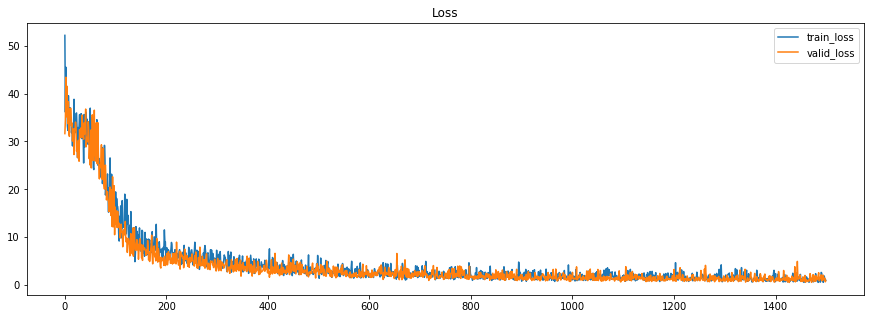

In [12]:
# plot loss
plot_loss.plot(title='Loss', figsize=(15, 5))
plt.show()

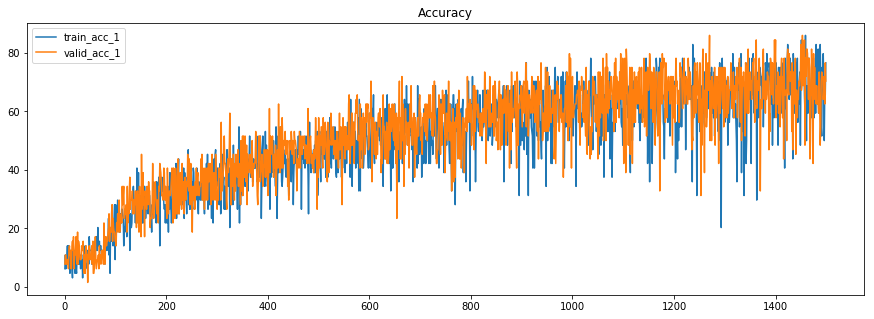

In [13]:
# plot accuracy to 1
plot_acc1.plot(title='Accuracy', figsize=(15, 5))
plt.show()

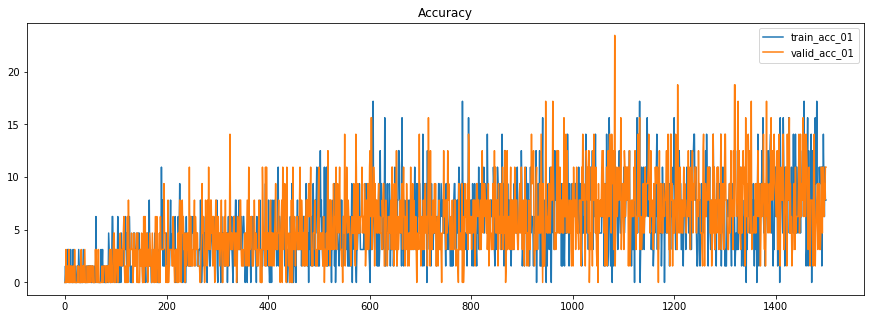

In [14]:
# plot accuracy 0.1
plot_acc01.plot(title='Accuracy', figsize=(15, 5))
plt.show()

## Evaluate model

In [15]:
batch_size = 100
data_test  = DataSet(angles_test, samples_test, 'test', batch_size=batch_size)
print("Number of test samples:  ", len(data_test.sample_paths))

Number of test samples:   1000


INFO:tensorflow:Restoring parameters from ./tf_model/model_tf

Average error = 0.785 degrees

Prediction examples:
Predicted =  0.32, Actual =  0.9
Predicted =  7.94, Actual =  9.4
Predicted =  1.02, Actual =  1.8
Predicted = -3.70, Actual = -3.8
Predicted = -0.04, Actual =  1.0
Predicted = -1.71, Actual = -2.3
Predicted =  1.66, Actual =  2.0
Predicted = -4.57, Actual = -4.1
Predicted = -3.40, Actual = -2.8
Predicted =  3.20, Actual =  2.2


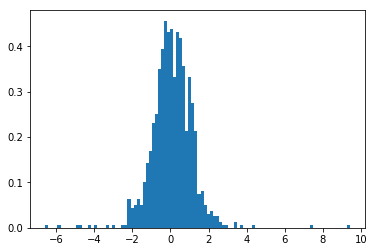

In [16]:
# evaluate model
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('./tf_model/model_tf.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./tf_model'))
    predictions_list = []
    truths_list = []
    images_list = []
    for i in range(len(data_test.sample_paths)//batch_size):
        test_batch_imgs, test_batch_lbls = data_test.get_next_batch()
        test_batch_imgs_norm = [img / 255. for img in test_batch_imgs]
        
        predictions = sess.run(prediction, feed_dict={images_ph: test_batch_imgs_norm, 
                                                      angles_ph: test_batch_lbls})
        predictions_list.extend(predictions)
        truths_list.extend(test_batch_lbls)
        images_list.extend(test_batch_imgs)
    
    error_list = [abs(i - j) for i, j in zip(predictions_list, truths_list)]
    mean_error = np.mean(error_list)
    print()
    print("Average error = {:.3f} degrees".format(mean_error))
    print()
    print("Prediction examples:")
    for i in range(10):
        print("Predicted = {0:5.2f}, Actual = {1:4.1f}".format(predictions_list[i],
                                                               truths_list[i]))
    plt.hist([i - j for i, j in zip(predictions_list, truths_list)], bins=100, normed=True)
    plt.show()

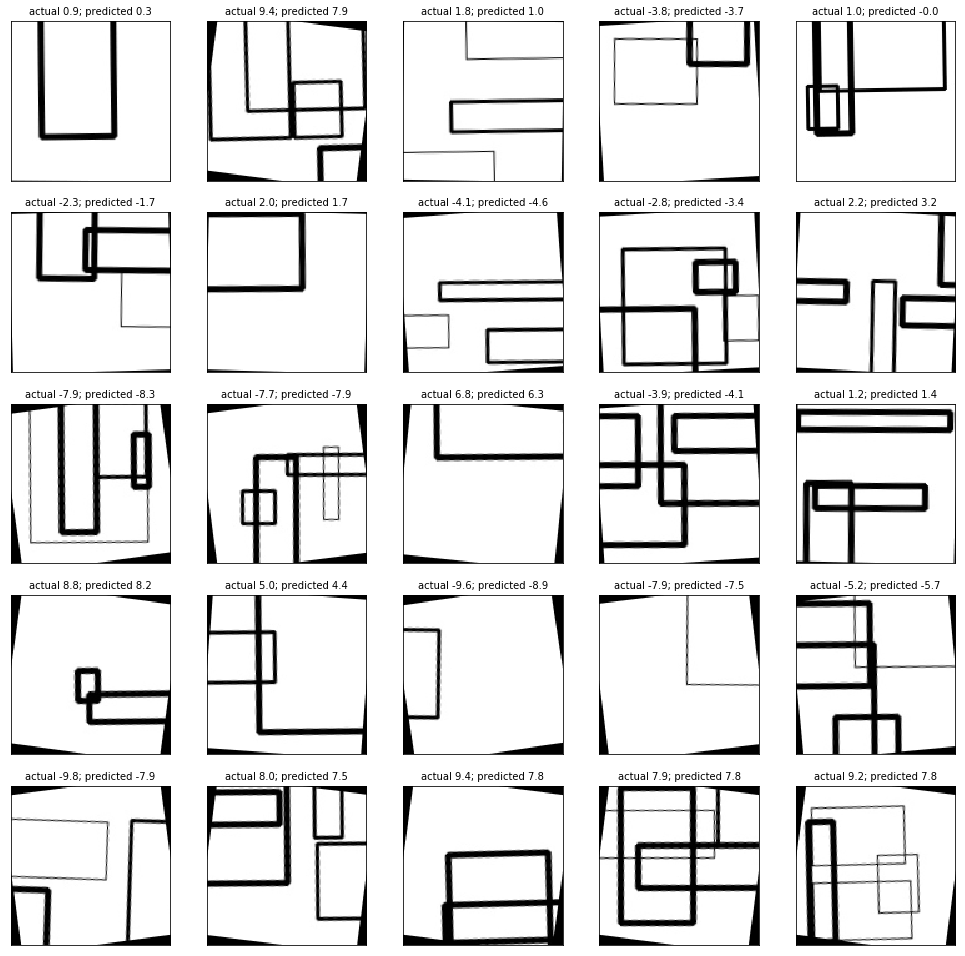

In [17]:
# angle correction
n_rows = 5
n_cols = 5
plt.figure(figsize=(17, 17))

# print corrected images
for i in range(n_rows*n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    image = images_list[i]
    angle = truths_list[i]
    predicted_angle = predictions_list[i]
    # correct rotation
    image = rotate(image, -predicted_angle)
    # plot image
    plt.title('actual {0:.1f}; predicted {1:.1f}'.format(angle, round(predicted_angle,1)), fontsize=10)
    plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
    plt.imshow(image)